# Fase de entrenamiento del modelo

Para este ejercicio, y dado que buscamos enfocarnos en la parte de explicabilidad, usaremos un clasificador Random Forest, para el cual las técnicas de SHAP son más efectivas a diferencia de una regresión logística que en esencia es un modelo altamente explicable por naturaleza.

Dicho lo anterior, a lo largo de este notebook, procederemos a cargar los datos pre-procesados, entrenar un modelo RandomForestClassifier y realizar una evaluación inicial de su rendimiento en el conjunto de prueba, pasos estandar para continuar con la asignación.

In [ ]:
# ====================================================================
# LIBRERÍAS
# ====================================================================
# Se importan las librerías necesarias para el modelado y la evaluación.
import pandas as pd
import pickle, os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    precision_recall_curve, 
    auc,
    roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# Configuraciones para una mejor visualización.
sns.set_style('whitegrid')
%matplotlib inline

# Carga de datos procesados y divididos

Realizamos acá la carga de datos para iniciar posteriormente con el entrenamiento del modelo mencionado:

In [3]:
# ====================================================================
# CARGA DE DATOS PROCESADOS
# ====================================================================
# Se cargan los conjuntos de datos previamente divididos y guardados en formato pickle.

DATA_PATH = "../Source/processed_data/split_data.pkl"

with open(DATA_PATH, 'rb') as file:
    processed_data = pickle.load(file)

X_train = processed_data["X_train"]
X_test = processed_data["X_test"]
y_train = processed_data["y_train"]
y_test = processed_data["y_test"]

print("Datos de entrenamiento y prueba cargados exitosamente.")
print(f"Tamaño de X_train: {X_train.shape}")
print(f"Tamaño de X_test: {X_test.shape}")
print(f"Tamaño de y_train: {y_train.shape}")
print(f"Tamaño de y_test: {y_test.shape}")

Datos de entrenamiento y prueba cargados exitosamente.
Tamaño de X_train: (227845, 29)
Tamaño de X_test: (56962, 29)
Tamaño de y_train: (227845,)
Tamaño de y_test: (56962,)


## Entrenamiento del Modelo de Clasificación

En referencia al modelo RandomForestClassifier, éste se caracteriza por su capacidad para manejar relaciones no lineales y su robustez.
Un parámetro clave en este paso es class_weight='balanced'. Esta es una técnica simple y efectiva para mitigar el fuerte desbalance de clases, instruyendo al modelo a "prestar más atención" a la clase minoritaria (fraude) durante el entrenamiento.

De esta forma, no profundizamos tanto en los parámetros del modelo ni en la forma del entrenamiento, por lo cual esto podría considerarse como una forma ingenua de proceder, pero es una desición conciente dado que no buscamos el mejor modelo para este caso, sino interpretar la forma en que el modelo clasifica.

In [4]:
# ====================================================================
# ENTRENAMIENTO DEL MODELO
# ====================================================================
# Se instancia y entrena el modelo RandomForestClassifier.

# 1. Instanciar el modelo.
#    - n_estimators=100: Número de árboles en el bosque (un buen punto de partida).
#    - class_weight='balanced': Parámetro crucial para manejar el desbalance de clases.
#    - random_state=42: Para garantizar la reproducibilidad de los resultados.
#    - n_jobs=-1: Utiliza todos los procesadores disponibles para acelerar el entrenamiento.
model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1 
)

# 2. Entrenar el modelo con los datos de entrenamiento.
print("Entrenando el modelo RandomForestClassifier...")
model.fit(X_train, y_train.values.ravel()) # .ravel() para asegurar el formato correcto de y_train
print("Entrenamiento completado.")

Entrenando el modelo RandomForestClassifier...
Entrenamiento completado.


## Evaluación de desempeño del modelo

Ahora evaluamos el modelo entrenado en los datos que nunca ha visto (X_test, y_test). Esto nos da una estimación realista de su rendimiento.

La evaluación se centrará en métricas que son significativas para problemas con datos desbalanceados.

- Matriz de Confusión: Para visualizar directamente los Falsos Positivos y Falsos Negativos.

- Reporte de Clasificación: Para ver Precision, Recall y F1-score de la clase minoritaria.

- Curva Precision-Recall y AUPRC: La métrica principal, tal y como se recomienda en la documentación oficial del dataset en Kaggle.

In [8]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(56962,))

In [14]:
y_test.values

array([0, 0, 0, ..., 0, 0, 0], shape=(56962,))

========================= Reporte de Clasificación =========================
               precision    recall  f1-score   support

No Fraude (0)       1.00      1.00      1.00     56864
   Fraude (1)       0.96      0.76      0.85        98

     accuracy                           1.00     56962
    macro avg       0.98      0.88      0.92     56962
 weighted avg       1.00      1.00      1.00     56962

=========================== Matriz de Confusión ============================


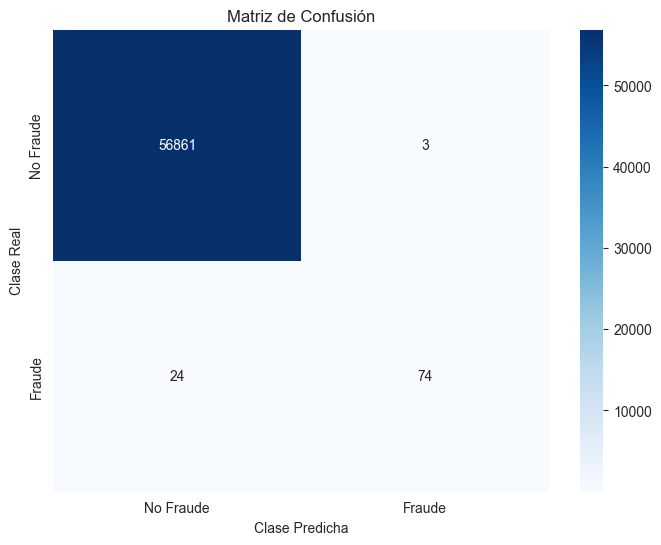

In [16]:
# ====================================================================
# PREDICCIONES Y MÉTRICAS BÁSICAS
# ====================================================================
# Se realizan predicciones sobre el conjunto de prueba.
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1] # Probabilidades para la clase positiva (fraude)

# 1. Reporte de Clasificación
print("="*25, "Reporte de Clasificación", "="*25)
print(classification_report(y_test.values, y_pred, target_names=['No Fraude (0)', 'Fraude (1)']))
# Nota: Observar el alto Recall para la clase 'Fraude', gracias a class_weight.

# 2. Matriz de Confusión
print("="*27, "Matriz de Confusión", "="*28)
cm = confusion_matrix(y_test.values, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Fraude', 'Fraude'], 
            yticklabels=['No Fraude', 'Fraude'])
plt.title('Matriz de Confusión')
plt.ylabel('Clase Real')
plt.xlabel('Clase Predicha')
plt.show()

## Evaluación Principal: Curva Precision-Recall (AUPRC)

Esta curva es la herramienta más informativa para evaluar un modelo de fraude. Muestra el trade-off entre la Precisión (¿qué proporción de las alertas de fraude son reales?) y el Recall (¿qué proporción de los fraudes reales logramos capturar?) a diferentes umbrales de probabilidad. El área bajo esta curva (AUPRC) nos da un puntaje único que resume el rendimiento del modelo.

In [18]:
y_pred_proba

array([0., 0., 0., ..., 0., 0., 0.], shape=(56962,))

In [19]:
y_test

263020    0
11378     0
147283    0
219439    0
36939     0
         ..
54199     0
184616    0
274532    0
269819    0
64170     0
Name: Class, Length: 56962, dtype: int64

Área Bajo la Curva Precision-Recall (AUPRC): 0.8573
Área Bajo la Curva ROC (AUC-ROC): 0.9580
--------------------------------------------------
Un AUPRC alto indica que el modelo puede alcanzar un alto Recall (capturar muchos fraudes) mientras mantiene una alta Precisión (sin generar demasiadas falsas alarmas).


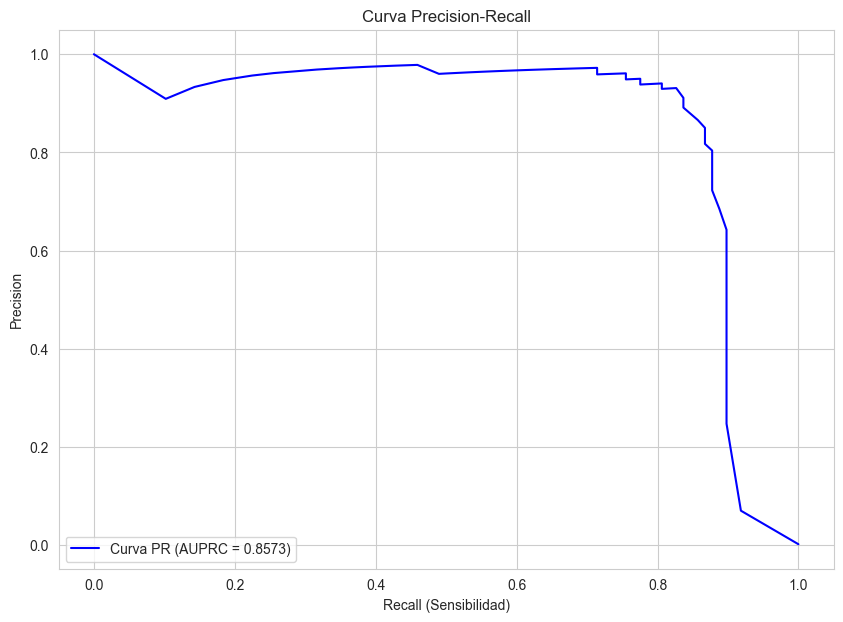

In [20]:
# ====================================================================
# CÁLCULO Y VISUALIZACIÓN DE LA CURVA PRECISION-RECALL
# ====================================================================

# 1. Calcular los puntos de la curva.
precision, recall, thresholds = precision_recall_curve(y_test.values, y_pred_proba)

# 2. Calcular el Área Bajo la Curva (AUPRC).
auprc = auc(recall, precision)

# Adicionalmente, calculamos el AUC-ROC como referencia.
roc_auc = roc_auc_score(y_test.values, y_pred_proba)

print(f"Área Bajo la Curva Precision-Recall (AUPRC): {auprc:.4f}")
print(f"Área Bajo la Curva ROC (AUC-ROC): {roc_auc:.4f}")
print("-" * 50)
print("Un AUPRC alto indica que el modelo puede alcanzar un alto Recall (capturar muchos fraudes) mientras mantiene una alta Precisión (sin generar demasiadas falsas alarmas).")

# 3. Visualizar la curva.
plt.figure(figsize=(10, 7))
plt.plot(recall, precision, color='b', label=f'Curva PR (AUPRC = {auprc:.4f})')
plt.title('Curva Precision-Recall')
plt.xlabel('Recall (Sensibilidad)')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

Con lo visto hasta el momento, podemos concluir que el modelo entrenado tiene un desempeño inicial bueno, pero que tiene aún un considerable margen para la mejora, dado que aún no logra capturar la mayoría de los casos marcados como fraude en el conjunto de prueba.

# Guardado del Modelo Entrenado

Finalmente, guardamos el modelo entrenado para que los siguientes cuadernos (3_Global_Explanations.ipynb y 4_Local_Explanations.ipynb) puedan cargarlo y aplicar las técnicas de explicabilidad.

In [ ]:
# ====================================================================
# GUARDADO DEL MODELO ENTRENADO
# ====================================================================
# Se guarda el objeto del modelo en un archivo pickle.

MODEL_SAVE_PATH = "../Source/models/fraud_classifier.pkl"
os.makedirs('../Source/models', exist_ok=True)

with open(MODEL_SAVE_PATH, 'wb') as file:
    pickle.dump(model, file)

print(f"Modelo guardado exitosamente en: {MODEL_SAVE_PATH}")

Modelo guardado exitosamente en: ../Source/models/fraud_classifier.pkl
